<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_19722/1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


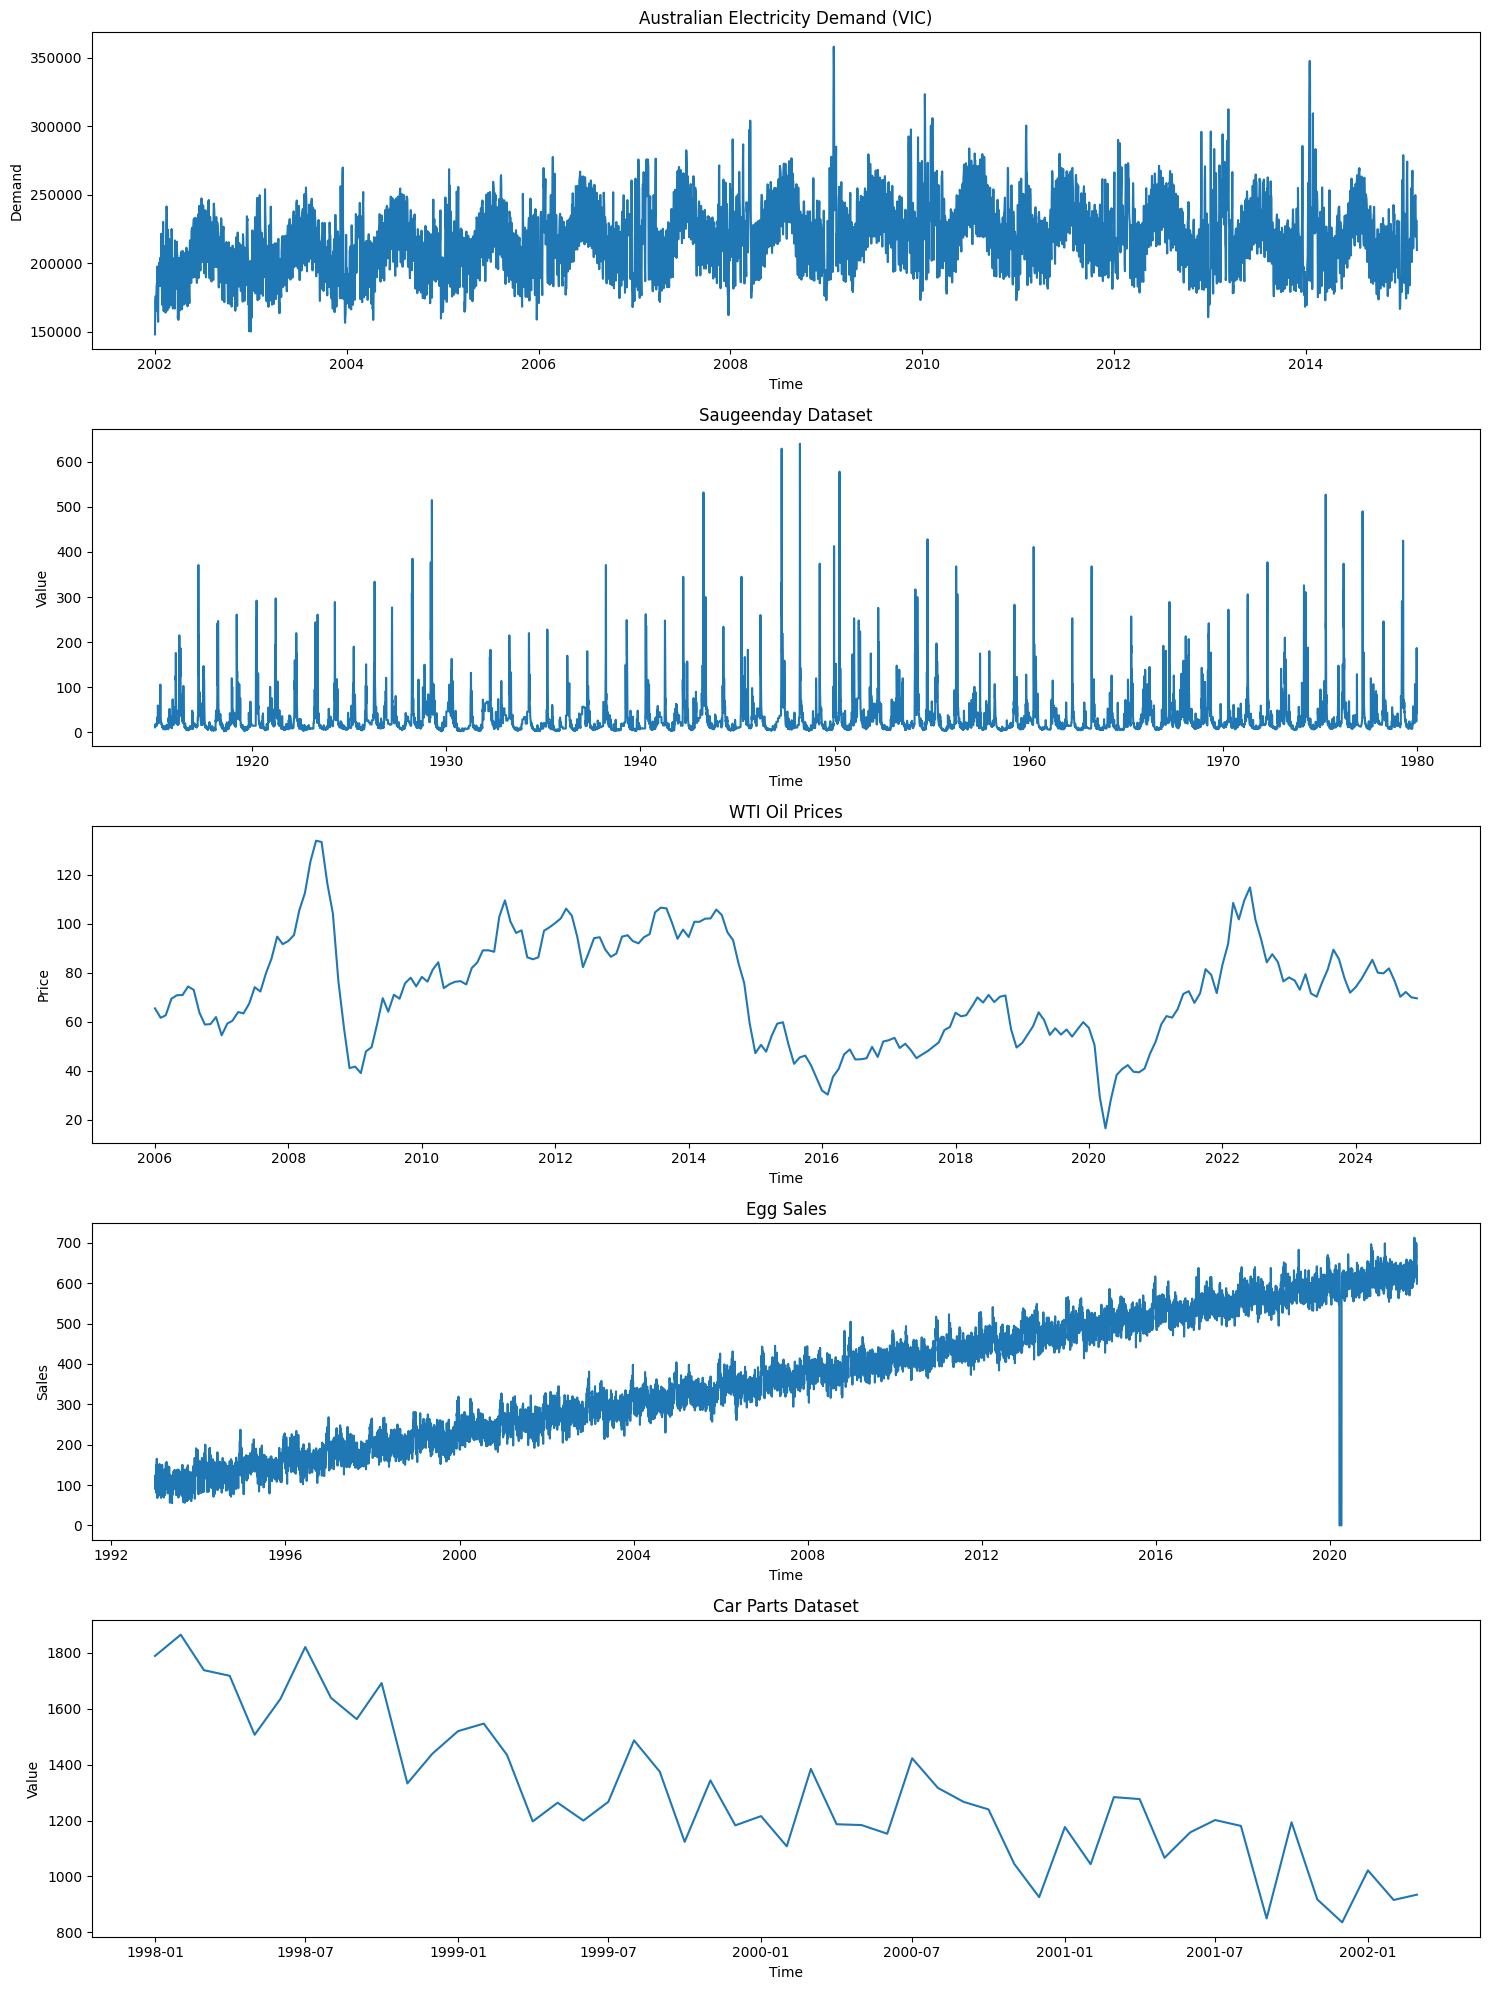

In [9]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

In [10]:
import timesfm
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset

def timesfm_forecast(train_df, test_df, alpha=0.05, show_plots=False,figsize=(14, 6)):
    """
    Fit TimesFM model and generate forecasts
    
    Parameters:
    -----------
    train_df : DataFrame with 'ds' and 'y' columns
    test_df : DataFrame with 'ds' and 'y' columns
    alpha : float, confidence interval width (default: 0.05 for 95% CI)
    figsize : tuple, figure size for plots (default: (14, 6))
    """
    # Calculate appropriate context length based on data
    # Use 25% of training data length, then round to nearest power of 2
    target_len = int(len(train_df) * 0.5)
    # Find nearest power of 2, staying between 128 and 1024
    context_len = 2 ** int(np.log2(target_len))  # Round down to power of 2
    if context_len < 128:
        context_len = 128  # Minimum 2^7
    elif context_len > 1024:
        context_len = 1024  # Maximum 2^10
    if show_plots:
        print(f"Using context_len={context_len} based on training data length of {len(train_df)}")
    tfm = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            per_core_batch_size=32,  # Batch size per GPU/TPU core. Higher batch sizes=more parallelism, but needs more memory.
            context_len=context_len, # Dynamically set based on dataset size
            horizon_len=len(test_df),# Forecasting horizon length
            input_patch_len=32,      # Length of input patches
            output_patch_len=128,    # Length of output patches
            num_layers=50,           # Number of transformer layers. More layers=more expressive model, but slower and heavier
            model_dims=1280,         # Dim. of transformer. A larger number means more powerful model, again at the cost of memory/speed.
            use_positional_embedding=False
        ),
        checkpoint=timesfm.TimesFmCheckpoint(huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
    )
    
    freq = pd.infer_freq(train_df['ds'])
    train_df['unique_id'] = '1'
    forecast = tfm.forecast_on_df(
        inputs=train_df,  # Input DataFrame containing the time-series data for training 
        freq=freq,        # Frequency of the time-series data (e.g., daily)
        value_name="y",   # Name of the column containing the values to be forecasted
        num_jobs=-1      # Number of parallel jobs to use for forecasting (-1 uses all available cores)
    )
    
    if show_plots:
        # Plot the results
        plt.figure(figsize=figsize)
        
        # Plot training data
        plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
        
        # Plot test data
        plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')
        
        # Plot forecast
        plt.plot(forecast['ds'], forecast['timesfm'], label='Forecast', color='red')
        
        # Plot confidence intervals if available
        if 'lower' in forecast.columns and 'upper' in forecast.columns:
            plt.fill_between(forecast['ds'],
                            forecast['lower'], 
                            forecast['upper'], 
                            color='red', 
                            alpha=0.2,
                            label=f'{int((1-alpha)*100)}% CI')
        split_date = test_df['ds'].iloc[0]
        plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')
        plt.title('TimesFM Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return forecast['timesfm'].values  # Return model as None since TimesFM doesn't expose it



Using context_len=128 based on training data length of 205


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 89240.51it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


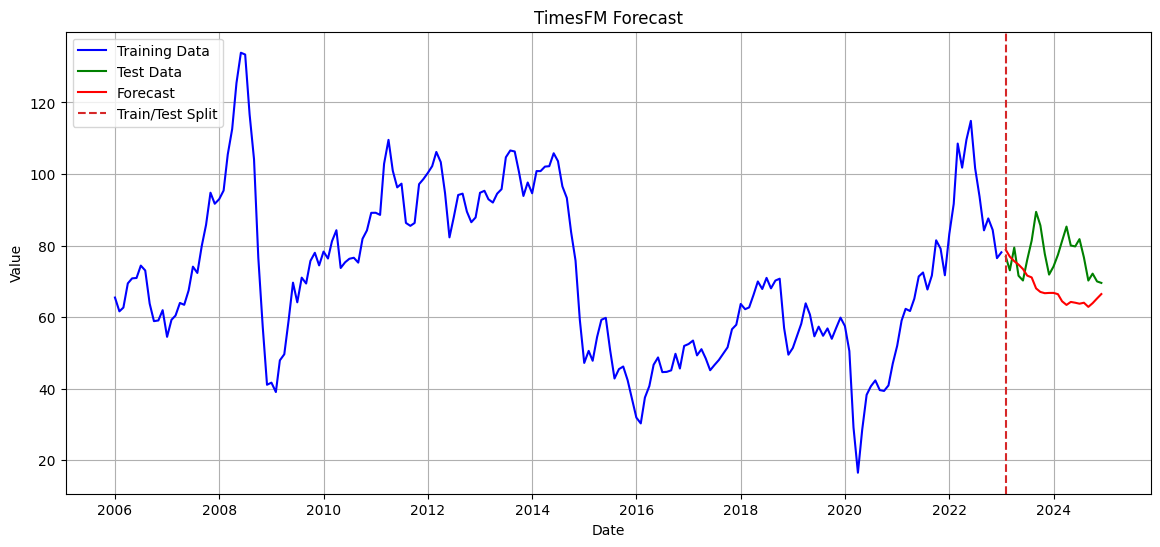

In [11]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)

Using context_len=1024 based on training data length of 21366


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 113359.57it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


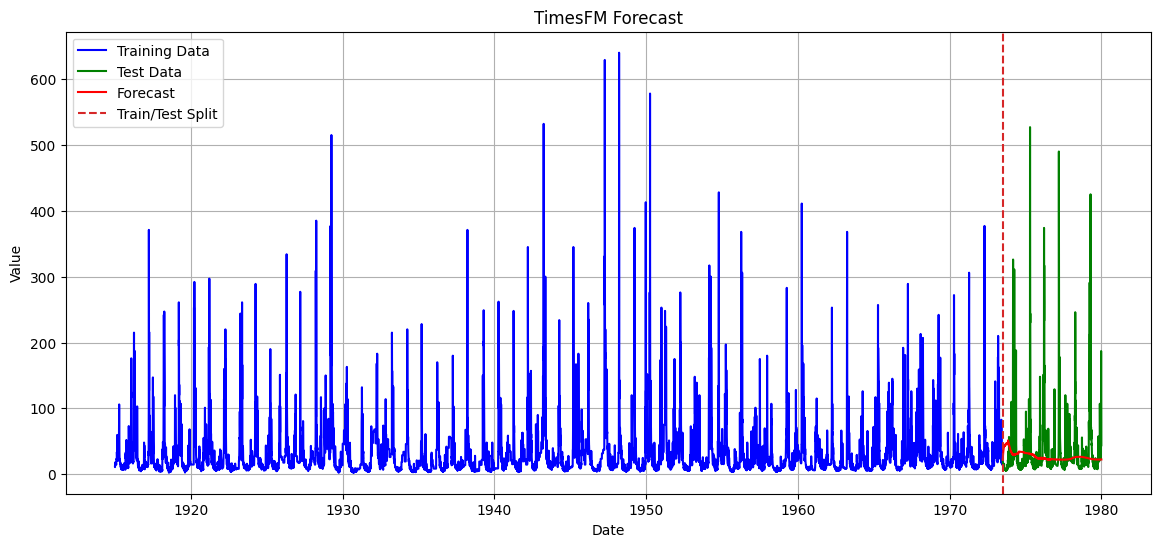

In [12]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)


Using context_len=1024 based on training data length of 9532


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 106454.42it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


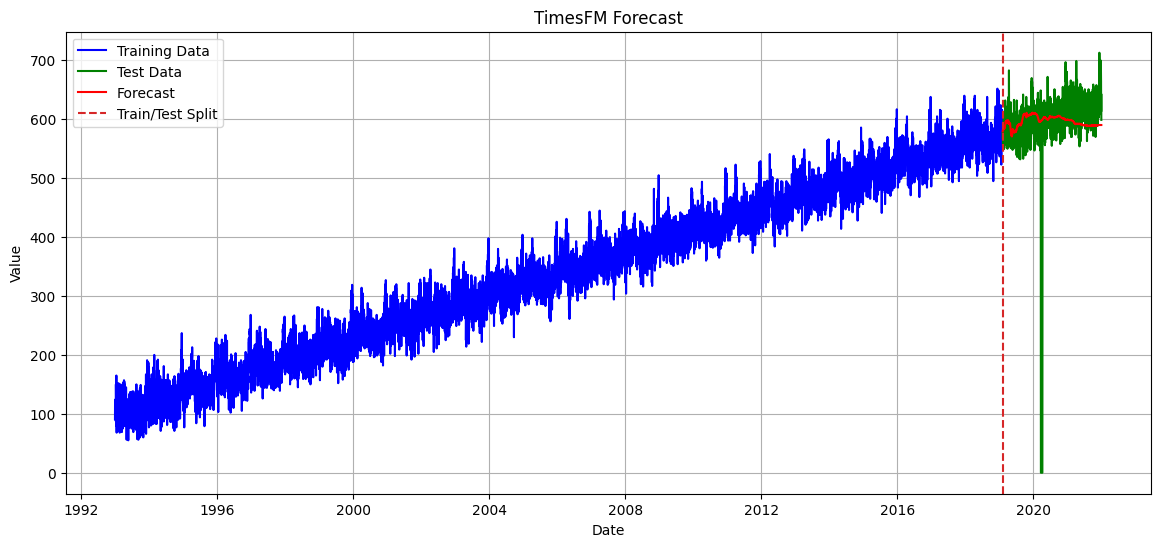

In [13]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)


In [14]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
)


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 131072.00it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Using context_len=128 based on training data length of 45


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 97997.76it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


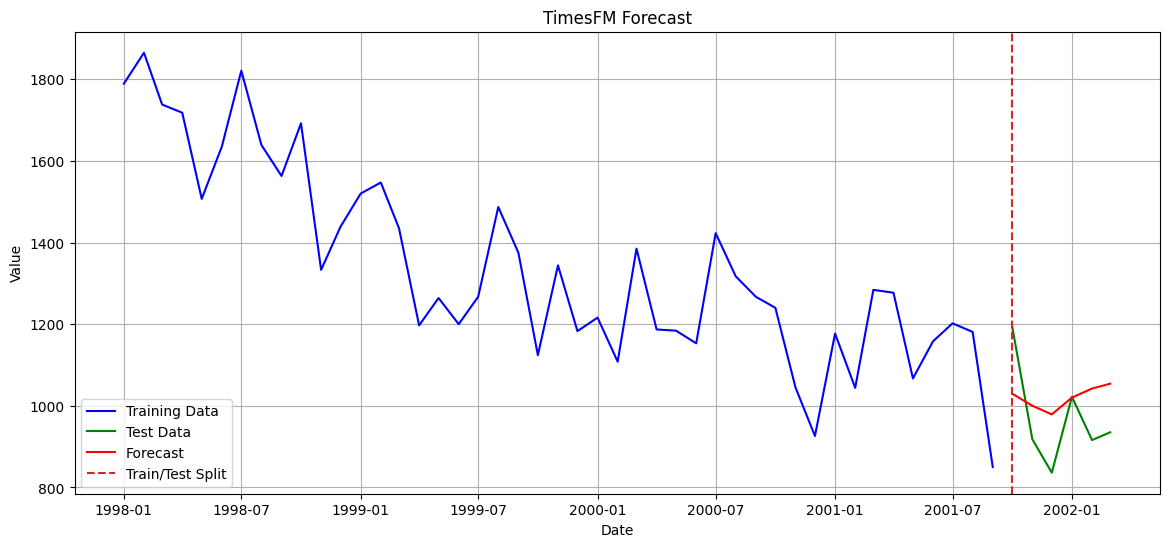

In [15]:
train_df, test_df = split_train_test(car_parts_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
    show_plots=True,
)


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 56833.39it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 97997.76it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 135300.13it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 128659.63it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 108100.62it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


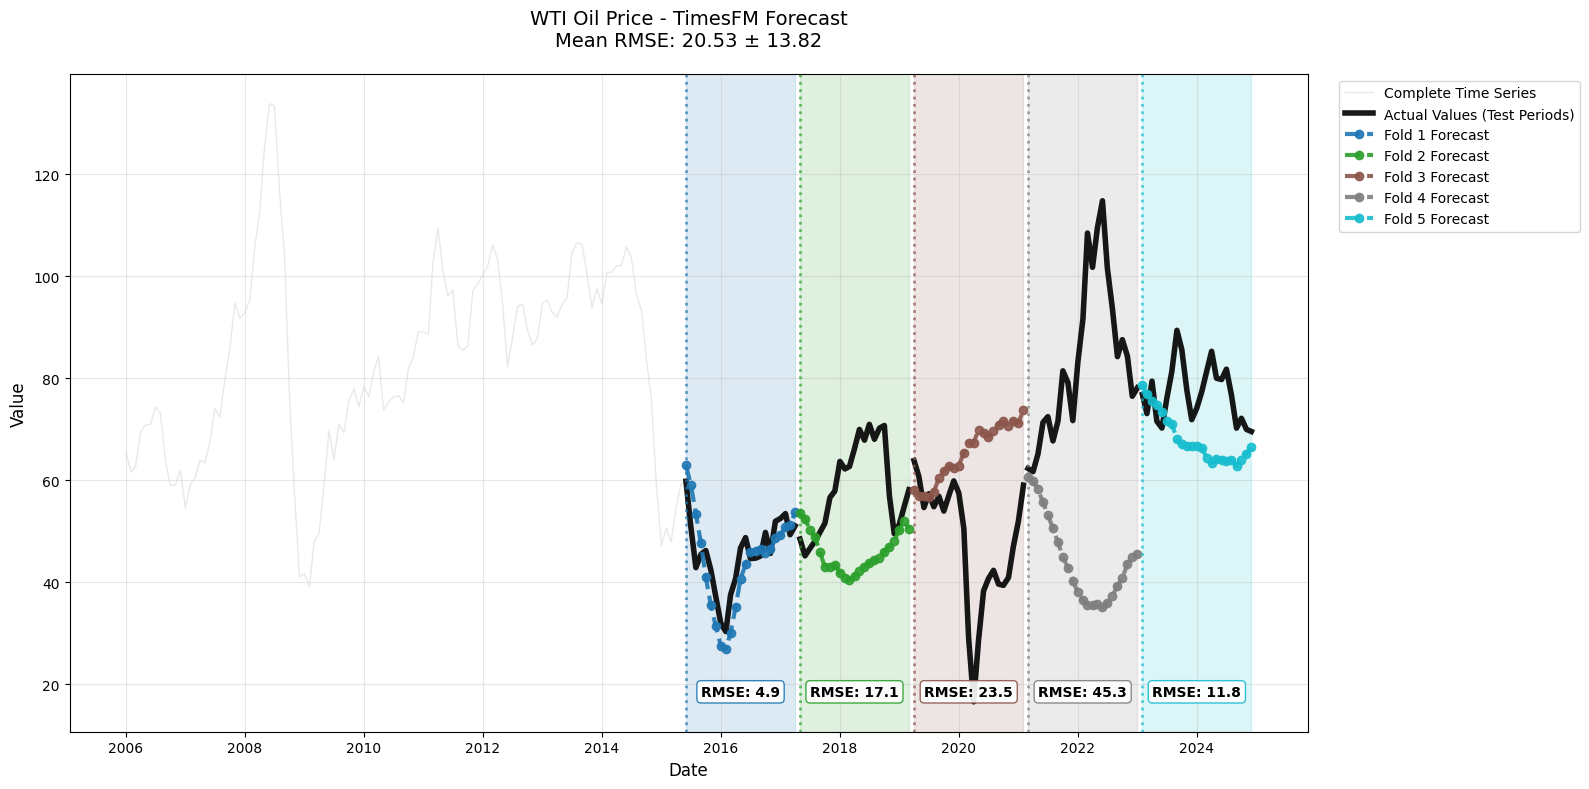

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 83220.32it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 83551.87it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 75709.46it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 113975.65it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 122640.47it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


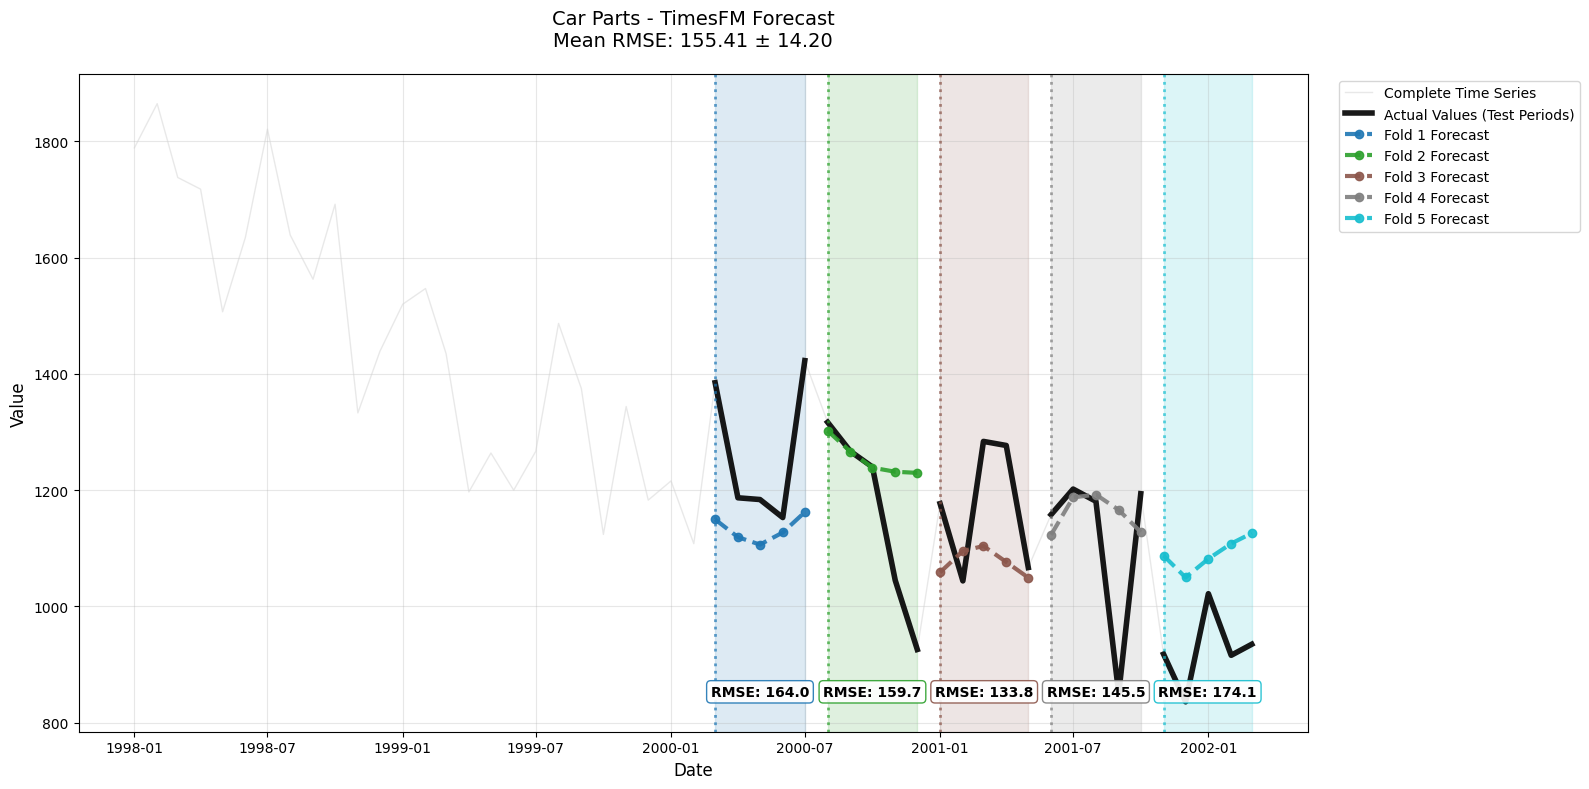

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 124830.48it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 119156.36it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 108660.73it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 131896.35it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 109226.67it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


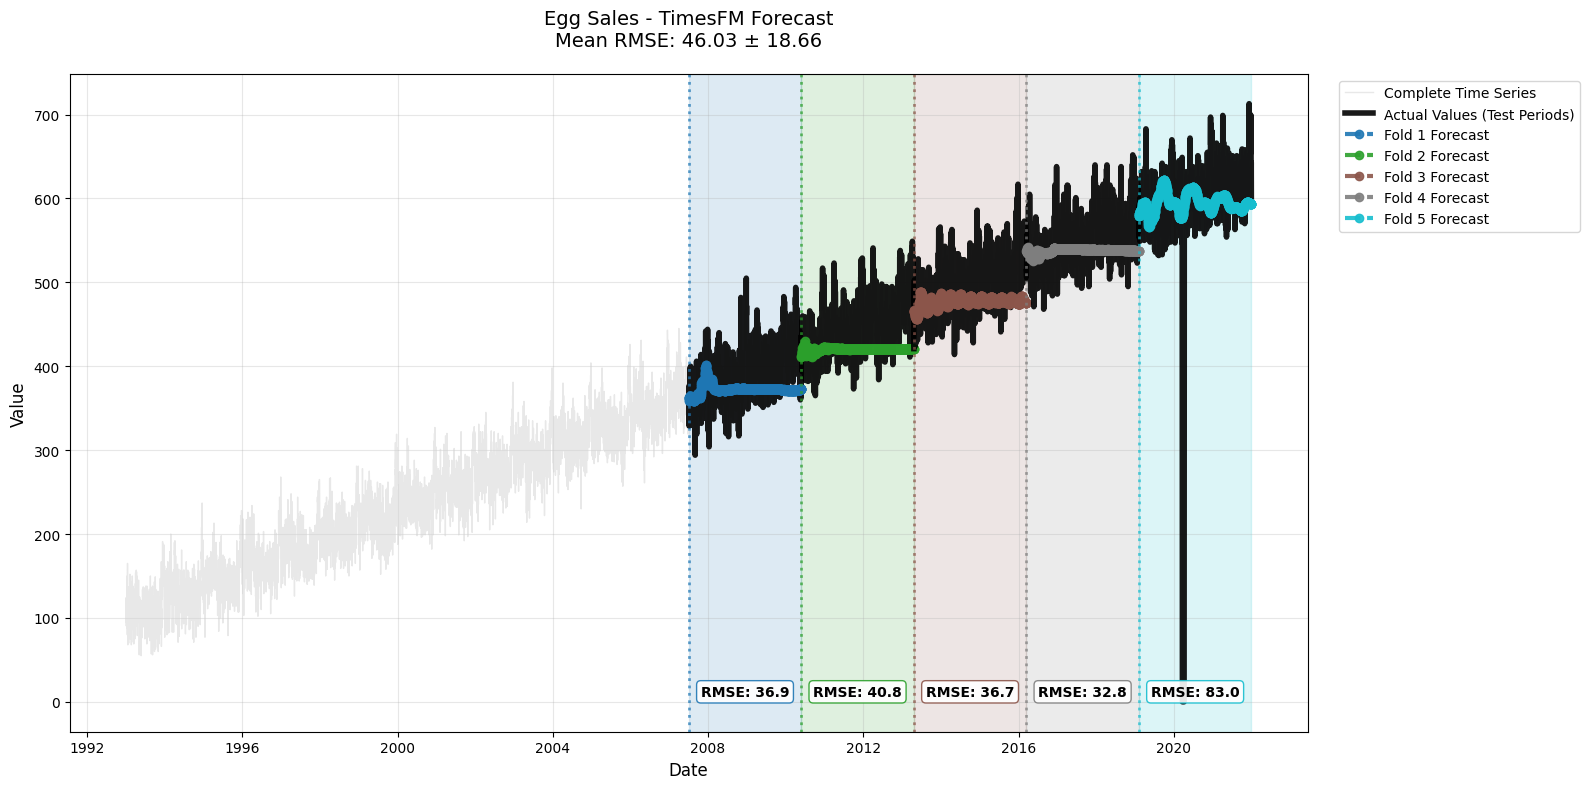

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 115864.75it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 142663.40it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 104335.92it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 137970.53it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 90785.80it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


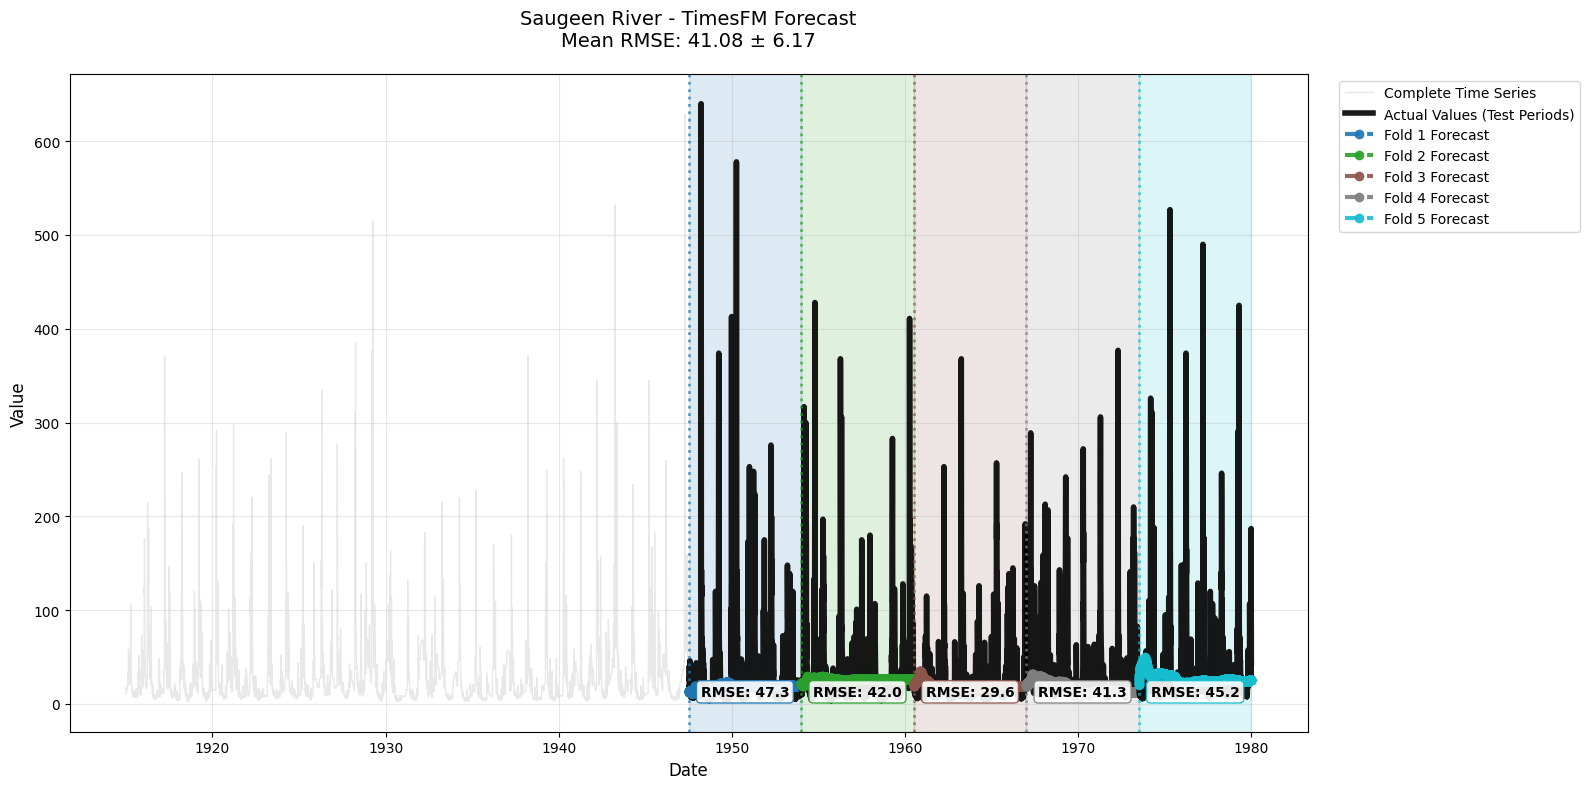

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 142663.40it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 131896.35it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 109226.67it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 95760.37it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 116508.44it/s]


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


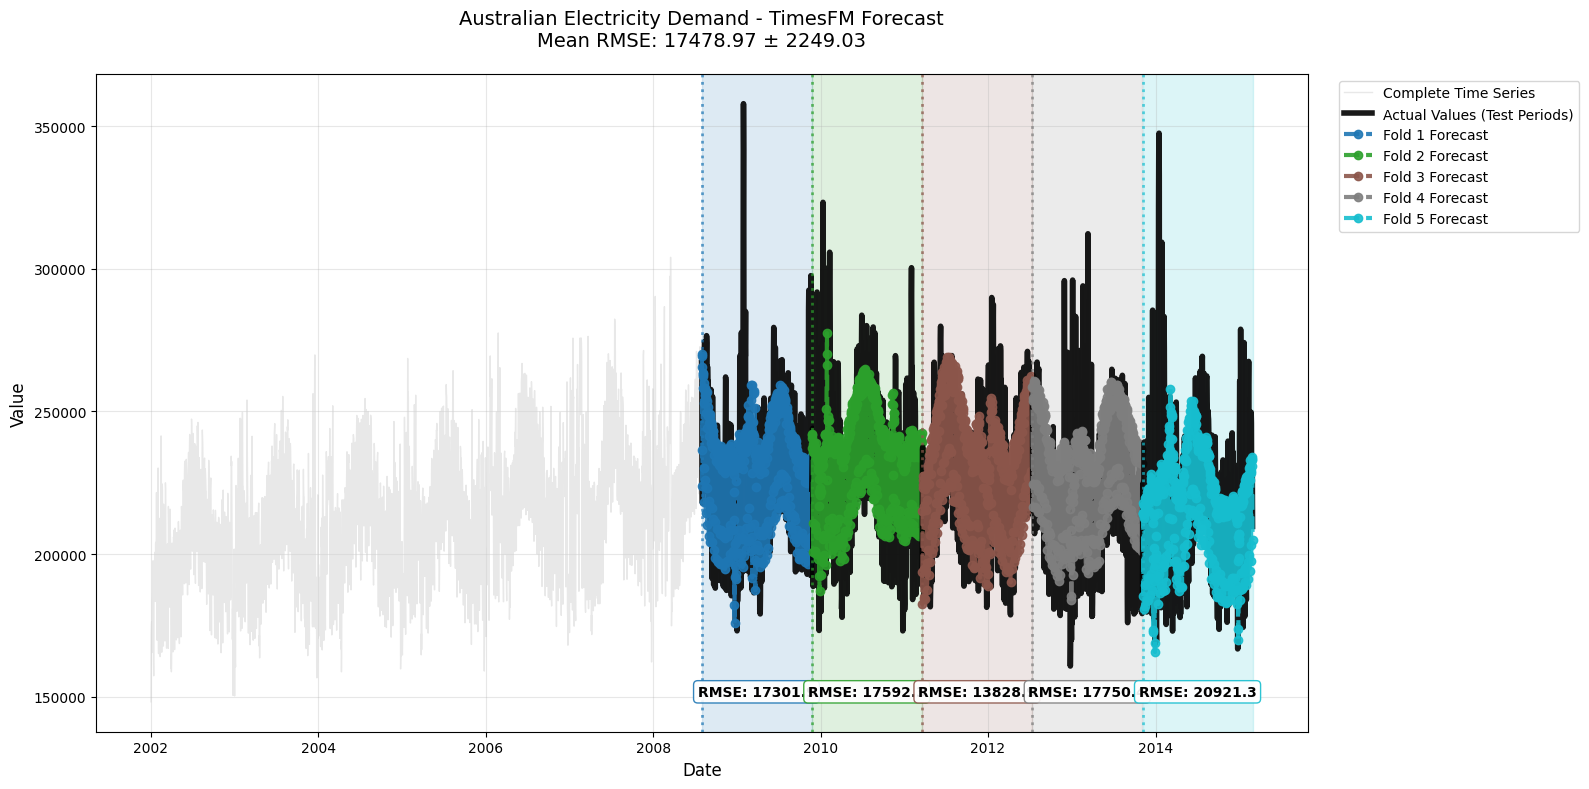

In [16]:
plot_comprehensive_cv_results(wti_oil_df, timesfm_forecast, n_splits=5, dataset_name='wti_oil',
                              title="WTI Oil Price - TimesFM Forecast")

plot_comprehensive_cv_results(car_parts_df, timesfm_forecast, n_splits=5, dataset_name='car_parts',
                              title="Car Parts - TimesFM Forecast")

plot_comprehensive_cv_results(egg_sales_df, timesfm_forecast, n_splits=5, dataset_name='egg_sales',
                              title="Egg Sales - TimesFM Forecast")
plot_comprehensive_cv_results(saugeen_river_df, timesfm_forecast, n_splits=5, dataset_name='saugeen_river',
                              title="Saugeen River - TimesFM Forecast")
plot_comprehensive_cv_results(australian_electricity_demand_df, timesfm_forecast, n_splits=5, dataset_name='australian_electricity_demand',
                              title="Australian Electricity Demand - TimesFM Forecast")